In [1]:
import os
import re
import json 

import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt 
from matplotlib import colors
import seaborn as sns 
import plotly.graph_objects as go 
import plotly.express as px 
from plotly.offline import init_notebook_mode
from plotly.subplots import make_subplots

from shapely.geometry import Polygon 
#import geopandas as gpd 
import folium
import folium.plugins

from IPython.display import HTML, display

init_notebook_mode(connected=True)

In [2]:
COUNTRY = 'India'
YEARS = [2018, 2019, 2020]

cities_dir = 'Cities/Cities Responses/'
cc_dir = 'Corporations/Corporations Responses/Climate Change/'
ws_dir = 'Corporations/Corporations Responses/Water Security/'

cities = [pd.read_csv(cities_dir + f'{year}_Full_Cities_Dataset.csv') for year in YEARS]
cc = [pd.read_csv(cc_dir + f'{year}_Full_Climate_Change_Dataset.csv') for year in YEARS]
ws = [pd.read_csv(ws_dir + f'{year}_Full_Water_Security_Dataset.csv') for year in YEARS]

cities_dir_disc = 'Cities/Cities Disclosing/'
cc_dir_disc = 'Corporations/Corporations Disclosing/Climate Change/'
ws_dir_disc = 'Corporations/Corporations Disclosing/Water Security/'

cities_disc = [pd.read_csv(cities_dir_disc + f'{year}_Cities_Disclosing_to_CDP.csv') for year in YEARS]
cc_disc = [pd.read_csv(cc_dir_disc + f'{year}_Corporates_Disclosing_to_CDP_Climate_Change.csv') for year in YEARS]
ws_disc = [pd.read_csv(ws_dir_disc + f'{year}_Corporates_Disclosing_to_CDP_Water_Security.csv') for year in YEARS]

In [3]:
def clean_city_name(city):
    return re.sub(r'City|of|Municipal|Corporation|Metropolitan|Area', '', city).strip()

In [4]:
cities[2]['Parent Section'].replace('City-wide Emissions', 'City Wide Emissions', inplace=True)
cities[0]['Parent Section'].replace('Water', 'Water Security', inplace=True)
cities[2]['Parent Section'].replace('Climate Hazards and Vulnerability', 'Climate Hazards & Vulnerability', inplace=True)
cities[0]['Parent Section'].replace('Climate Hazards', 'Climate Hazards & Vulnerability', inplace=True)

cities_country = list(map(lambda df: df[df['Country'] == COUNTRY], cities))

cities_country_uniquesections = [df['Parent Section'].value_counts() for df in cities_country]
cities_country_sum = [df.sum(axis=0) for df in cities_country_uniquesections]
cities_country_uniquesections_normalized = [
    df / sum_ * 100 for df, sum_ in zip(cities_country_uniquesections, cities_country_sum)]
fig = go.Figure()
#make_subplots(rows=1, cols=3, shared_yaxes=True, subplot_titles=(f'2018 (N={cities_country_sum[0]})', f'2019 (N={cities_country_sum[1]})', f'2020 (N={cities_country_sum[2]})'), x_title='Questionnaire Section', y_title='# of responses')
for i, df in enumerate(cities_country_uniquesections_normalized):
    fig.add_trace(go.Bar(
        y=df.index, x=df, orientation='h',
        name=f'{i+2018} (N={cities_country_sum[i]})'))
fig.update_layout(
    title={
        'text': 'Sections Ranked by Number of Data Points -- India',
        'font_size': 20, 'yanchor':'top', 'x':0.5},
    yaxis={
        'categoryorder':'category descending',
        'title_text':'Questionnaire Section'},
    xaxis_title_text='% of year\'s responses',
    legend={
        'xanchor':'right', 'x':0.99, 'y':0.5
    })
fig.show()

In [5]:
cities_country_uniqueorgs = [df['Organization'].value_counts() for df in cities_country]

fig = make_subplots(
    rows=1, cols=3, shared_yaxes=True, 
    subplot_titles=('2018', '2019', '2020'), 
    x_title='Cities', y_title='# of responses')
for i, df in enumerate(cities_country_uniqueorgs):
    fig.add_trace(go.Bar(x=df.index.map(clean_city_name), y=df), row=1, col=i+1)
fig.update_layout(
    title={
        'text':'Indian Cities Disclosing to CDP', 
        'font_size':24, 'yanchor':'top', 'x':0.5},
    showlegend=False,
    xaxis={'tickangle':-70},
    xaxis2={'domain':[0.35,0.8]},
    xaxis3={'domain':[0.85,1]})
fig.layout.annotations[1]['xshift'] = 30
fig.layout.annotations[2]['xshift'] = 40
fig.layout.annotations[3]['yshift'] = -50
fig.layout.annotations[3]['xshift'] = 30
fig.show()

# CITY WIDE EMISSIONS 2018
## Kolkata, Jaipur, Chennai, Delhi, Bangalore
### ~36 question responses

In [6]:
def qnum_sorter(qnum):
    def sort(num):
        sections = num.split('.')
        second = re.search(r'\d+', sections[1])[0]
        letter = re.search(r'[a-z]', sections[1])
        return [int(sections[0]), int(second), letter[0] if letter else '']
    return pd.Index(qnum.map(sort))
    
def labelize(row_or_col):
    if row_or_col == 'row':
        return lambda row: (row[NUM_R], f'{row[NUM_R]}. {row[NAME_R]}')
    return lambda col: (col[NUM_C], f'{col[NUM_C]}. {col[NAME_C]}')

In [7]:
NUM_Q = 'Question Number'
NUM_R = 'Row Number'
NUM_C = 'Column Number'

NAME_Q = 'Question Name'
NAME_R = 'Row Name'
NAME_C = 'Column Name'

ANS = 'Response Answer'

In [8]:
import plotly.figure_factory as ff
pd.set_option('display.max_rows', 200)
# 2.1 => climate hazards
ordinals = {
    'Magnitude of expected future impact': ['High', '', 'Medium', '', 'Low'],
    'When do you first expect to experience these changes?': ['Immediately', 'Short-term (by 2025)', 'Medium-term (2026-2050)', '', 'Long-term (after 2050)'],
    'Current probability of hazard': ['High', 'Medium High', 'Medium', 'Medium Low', 'Low'],
    'Current consequence of hazard': ['High', 'Medium High', 'Medium', 'Medium Low', 'Low'],
    'Future change in frequency': ['', 'Increasing', 'None', 'Decreasing', ''],
    'Future change in intensity': ['Increasing', '', 'None', '', 'Decreasing']}
extras = [
    'Social impact of hazard overall',
    #'Most relevant assets/ services affected overall',
    'Please identify which vulnerable populations are affected']
cols = ['Climate Hazards'] + list(ordinals.keys()) + extras
df = cities_country[1]
df = df[(df[NUM_Q] == '2.1') & (df[NAME_C].isin(cols))]
orgs = df['Organization'].unique()
#print(orgs)
def hazards_scale(row):
    if row[NAME_C] == 'Climate Hazards': return row[ANS]
    if row[ANS] is np.NaN or row[ANS] == 'Do not know' or row[NAME_C] in extras: return np.NaN
    return 5 - ordinals[row[NAME_C]].index(row[ANS])
def first_or_list(series):
    if len(series) == 1:
        return series
    return list(series)
df['scaled'] = df.apply(hazards_scale, axis=1)
#df[df[NAME_C] == 'Climate Hazards'][ANS].fillna('hazard unspecified', inplace=True)
data_text = df.groupby(['Organization', NUM_R, NAME_C])[ANS].aggregate(first_or_list).unstack()
data_scale = df.groupby(['Organization', NUM_R, NAME_C])['scaled'].aggregate(lambda x: x).unstack()
for org in orgs[:-3]:
    text = data_text.query('Organization == @org').set_index('Climate Hazards')
    scale = data_scale.query('Organization == @org').set_index('Climate Hazards')
    if org == 'Indore Municipal Corporation':
        text = text.set_index(
            pd.Index(text.index[:-1].values.tolist() + [text.index[-1] + ' (1)']))
        scale = scale.set_index(
            pd.Index(scale.index[:-1].values.tolist() + [scale.index[-1] + ' (1)']))
    metrics = [key for key in ordinals if key in text.columns.values]
    fig = ff.create_annotated_heatmap(
        scale[metrics].values.tolist(), 
        x=text[metrics].columns.values.tolist(), 
        y=text.index.values.tolist(), 
        annotation_text=text[metrics].fillna('').values.tolist(),
        customdata=pd.concat(
            [text[extras].apply(
                lambda row: (
                    '<br>&#09;&#09;&#09;&#09;'.join(row[extras[0]])\
                        if row[extras[0]] is not np.NaN\
                        else row[extras[0]],
                    '<br>&#09;&#09;&#09;&#09;'.join(row[extras[1]])\
                        if row[extras[1]] is not np.NaN\
                        else row[extras[1]]),
                axis=1
            )] * len(metrics), axis=1).values.tolist(),
        hoverlabel_align='left',
        hovertemplate=''.join([
            '<b>x</b>: %{x}<br>',
            '<b>y</b>: %{y}<br>',
            '<b>z</b>: %{z}<br>',
            '<b>Social Impact:</b><br>',
            '&#09;&#09;&#09;&#09;%{customdata[0]}<br>',
            '<b>Vulnerable Populations:</b><br>',
            '&#09;&#09;&#09;&#09;%{customdata[1]}',
            '<extra></extra>']),
        colorscale='Electric',
        zmin=1, zmax=5,
        colorbar={
            'tickfont_size':10,
            'title':{
                'text':'Severity',
                'font_size':10}},
        font_colors=['black', 'white'],
        showscale=True,
        reversescale=True)
    fig.update_layout(
        title={
            'text':f'{clean_city_name(org)} 2019 2.1 -- Climate Hazards', 
            'yref':'container', 'y': 0.1, 'yanchor':'mid dle',
            'xref':'paper', 'x':0.5, 'xanchor':'center'},
        xaxis={'showgrid': False},
        yaxis={'showgrid': False},
        width=900)
    for i in range(len(fig.layout.annotations)):
        fig.layout.annotations[i]['font']['size'] = 10
        if fig.layout.annotations[i]['text'] in ('Do not know', 'Low'):
            fig.layout.annotations[i]['font']['color'] = 'black'
    fig.show()


In [78]:
# Retrograde emissions reporting 2019 4.12
pd.set_option('display.max_rows', 200)
df = cities_country[1][['Organization', NUM_R, NAME_C, ANS, NUM_Q, NUM_C]]
df['Organization'] = df['Organization'].map(clean_city_name)
df = df[(df[NUM_Q] == '4.12') & (df[NUM_C].isin([1,2,3,4]))].sort_values(by=[NAME_C])
for org in np.sort(df['Organization'].unique()):
    dff = df[df['Organization'] == org]
    dff = dff.iloc[:-1,:].pivot(index=NUM_R, columns=NAME_C)[ANS]
    print(org)
    display(dff)
#df[ANS] = df[ANS].map(lambda val: val.split(' ')[:3] + [' '.join(val.split(' ')[3:]#)])
#df[['from', 'to', 'emissions', 'scope']] = pd.DataFrame(df[ANS].tolist(), #index=df.index)
#df = df.drop(ANS, axis=1)
#df
#for idx, row in df.iterrows():
#    print(clean_city_name(row['Organization']), row)

Bangalore


Column Name,Inventory date from,Inventory date to,Previous emissions (metric tonnes CO2e)
Row Number,,,
0,NaN,NaN,NaN


Chennai


Column Name,Inventory date from,Inventory date to,Previous emissions (metric tonnes CO2e),Scopes / boundary covered
Row Number,,,,
1,2015-01-03,2016-03-03,NaN,Scope 2 (indirect)


Delhi


Column Name,Inventory date from,Inventory date to,Previous emissions (metric tonnes CO2e)
Row Number,,,
1,NaN,NaN,NaN


Gangtok


Column Name,Inventory date from,Inventory date to,Previous emissions (metric tonnes CO2e)
Row Number,,,
0,NaN,NaN,NaN


Guwahati


Column Name,Inventory date from,Inventory date to,Previous emissions (metric tonnes CO2e)
Row Number,,,
0,NaN,NaN,NaN


Indore


Column Name,Inventory date from,Inventory date to,Previous emissions (metric tonnes CO2e)
Row Number,,,
0,NaN,NaN,NaN


Jaipur


Column Name,Inventory date from,Inventory date to,Previous emissions (metric tonnes CO2e)
Row Number,,,
0,NaN,NaN,NaN


Kochi


Column Name,Inventory date from,Inventory date to,Previous emissions (metric tonnes CO2e)
Row Number,,,
0,NaN,NaN,NaN


Kolkata


Column Name,Inventory date from,Inventory date to,Previous emissions (metric tonnes CO2e)
Row Number,,,
0,NaN,NaN,NaN


Nagpur


Column Name,Inventory date from,Inventory date to,Previous emissions (metric tonnes CO2e)
Row Number,,,
1,2016-04-01,2017-03-31,2716191.5


Panaji


Column Name,Inventory date from,Inventory date to,Previous emissions (metric tonnes CO2e),Scopes / boundary covered
Row Number,,,,
1,2010-04-01,2011-03-01,154914,Total emissions
2,2010-04-01,2011-03-01,74216,Scope 1 (direct)
3,2011-04-01,2012-03-01,140366,Total emissions
4,2011-04-01,2012-03-01,77052,Scope 1 (direct)
5,2012-04-01,2013-03-01,151227,NaN
6,2012-04-01,2013-03-01,73028,Scope 1 (direct)
7,2013-04-01,2013-03-01,147168,Total emissions
8,2013-04-01,2013-02-26,69183,Scope 1 (direct)


Pune


Column Name,Inventory date from,Inventory date to,Previous emissions (metric tonnes CO2e)
Row Number,,,
0,NaN,NaN,NaN


ValueError: Index contains duplicate entries, cannot reshape

In [10]:
print('Delhi emissions (IPCC format) 4.6d')
print('------------------------------')
df = cities_country[1]
df = df[(df['Organization'] == 'City of Delhi') & (df[NUM_Q] == '4.6d')]
sectors = df[df[NAME_C] == 'IPCC sector'][ANS]
values = df[df[NAME_C] == 'Emissions (metric tonnes CO2e)'][ANS]
specifics = df[df[NAME_C] == 'IPCC sector']['Comments'].values[0]
for val in specifics.split('tCO2e')[:-1]:
    print(val)
print('')
for sector, val in zip(sectors, values):
    print(sector, '-', val)

Delhi emissions (IPCC format) 4.6d
------------------------------
Incinerator - 267,288 
MSW Burning - 3,123,102 
Landfill - 93,664 
Livestock- 567,316 
Agriculture - 79,749 
Cropland - 393,599 
Industry Area Source - 526,535 

Industrial Processes and Product Use (IPPU) - 3484.05
Agriculture, Forestry and Other Land Use (AFOLU) - 526.54
Waste - 1040.66


In [11]:
# Chennai, Kolkata, Nagpur, Rajkot 2019 4.6b => GHG emissions by sector
df = cities_country[1]
data = df[(df[NUM_Q] == '4.6b') & (df[NUM_C] == 1)][[NAME_R, ANS, 'Organization']]
specifics = data[~data[NAME_R].str.contains('TOTAL')]
totals = data[data[NAME_R].str.contains('TOTAL')]

fig = go.Figure()
for org in specifics['Organization'].unique():
    df = specifics[specifics['Organization'] == org].sort_values(by=[NAME_R])
    fig.add_trace(go.Bar(x=df[ANS], y=df[NAME_R], name=clean_city_name(org), text=df[ANS], textposition='outside', orientation='h', texttemplate='%{text:.2s}'))
fig.update_layout(
    title_text='GHG emissions by Sector (2019 - 4.6b)',
    title_xanchor='center',
    title_x=0.5,
    title_xref='paper',
    xaxis_type='log',
    xaxis_title_text='Emissions (metric tonnes CO2e)',
    width=1000,
    height=900,
    legend_orientation='h',
    legend_y=1, legend_yanchor='bottom', legend_x=0.1
)

fig.show()

In [12]:
# Chennai 2018 7.3a => GHG emissions by sector
df = cities_country[0]
data = df[(df['Organization'] == 'Corporation of Chennai') & (df[NUM_Q] == '7.3a')][[NAME_R, ANS]]
data = data[~data[NAME_R].str.contains('TOTAL')].sort_values(by=[NAME_R])
fig = go.Figure()
fig.add_trace(go.Bar(x=data[ANS], y=data[NAME_R], text=data[ANS], textposition='auto', orientation='h'))
fig.update_layout(
    title_text='Chennai 2018 7.3a => GHG emissions by sector',
    title_xanchor='center',
    title_x=0.5,
    xaxis_title_text='Emissions (metric tonnes CO2e)',
    width=1000
)

fig.show()

In [14]:
# Kolkata 2018 2.2a => Climate Hazards
import plotly.figure_factory as ff

ordinals = {
    'Magnitude of impact': ['Extremely serious', 'Serious', 'Less serious'],
    'Anticipated timescale': ['Long-term', '', 'Medium-term', '', 'Short-term'],
    'Probability of hazard': ['High', 'Medium High', 'Medium', 'Medium Low', 'Low'],
    'Consequence of hazard': ['High', 'Medium High', 'Medium', 'Medium Low', 'Low'],
    'Future change in frequency': ['', 'Increasing', 'None', 'Decreasing', ''],
    'Future change in intensity': ['Increasing', '', 'None', '', 'Decreasing']}
cols = ['Climate Hazards'] + list(ordinals.keys())
df = cities_country[0]
df = df[(df['Organization'] == 'Kolkata Metropolitan Area') \
        & (df[NUM_Q] == '2.2a') \
        & (df[NAME_C].isin(cols))]

def hazards_scale(row):
    if row[NAME_C] == 'Climate Hazards': return row[ANS]
    if row[ANS] is np.NaN: return np.NaN
    return 5 - ordinals[row[NAME_C]].index(row[ANS])
df['scaled'] = df.apply(hazards_scale, axis=1)
data = df[[NUM_R, NAME_C, ANS, 'scaled']].pivot(index=NUM_R, columns=NAME_C)
data_text = data[ANS].set_index('Climate Hazards')
data_scale = data['scaled'].set_index('Climate Hazards')

fig = ff.create_annotated_heatmap(
    data_scale.values.tolist(), 
    x=data_text.columns.values.tolist(), 
    y=data_text.index.values.tolist(), 
    annotation_text=data_text.fillna('').values.tolist(),
    colorscale='Electric',
    colorbar={
        'tickfont_size':10,
        'title':{
            'text':'Severity',
            'font_size':10}},
    font_colors=['black', 'white'],
    showscale=True,
    reversescale=True)
fig.update_layout(
    title={
        'text':'Kolkata 2018 2.2a -- Climate Hazards', 
        'yref':'container', 'y': 0.1, 'yanchor':'middle',
        'xref':'paper', 'x':0.5, 'xanchor':'center'},
    xaxis={'showgrid': False},
    yaxis={'showgrid': False})
for i in range(len(fig.layout.annotations)):
    fig.layout.annotations[i]['font']['size'] = 10
fig.show()

In [18]:
from jinja2 import Template
from folium.features import DivIcon

maps_responses = [folium.Map(
    width='33.3%' if left != '33.3%' else '33.4%',
    left=left, position='absolute',
    zoom_start=4, zoom_control=False, max_zoom=7,
    tiles='CartoDB dark_matter',
    location=[23,80]
) for left in ('0%', '33.3%', '66.7%')]

with open('constants.json') as f:
    latlong = json.load(f)

cmap = plt.get_cmap('spring_r')
norm = colors.Normalize(vmin=295, vmax=1517)
for i, in_orgs in enumerate(cities_country):
    df = in_orgs['Organization'].value_counts()
    for city in df.index:
        count = df[city]
        color = colors.to_hex(cmap(norm(count)))
        folium.CircleMarker(
            location=latlong[clean_city_name(city)],
            radius=30 * count / 1517,
            popup=f'{city}<br/>({count})',
            color=color,
            fill=True,
            fill_color=color
        ).add_to(maps_responses[i])
for i, year in enumerate((2018, 2019, 2020)):
    folium.map.Marker(
        [30, 80],
        icon=DivIcon(
            icon_size=(155,50), 
            icon_anchor=(-40, 100), 
            html=f'<div style="font-size:24px;"><p style="color:white;">{year}</p></div>')
    ).add_to(maps_responses[i])


# Interactive Map with separately pannable sections for each year
from branca.element import Figure
fig = Figure()
for map_ in maps_responses:
    fig.add_child(map_)
#display(HTML(fig._repr_html_()))

class TriMap(folium.plugins.DualMap):
    _template = Template("""
        {% macro script(this, kwargs) %}
            {{ this.m1.get_name() }}.sync({{ this.m2.get_name() }});
            {{ this.m2.get_name() }}.sync({{ this.m1.get_name() }});
            {{ this.m3.get_name() }}.sync({{ this.m1.get_name() }});
            {{ this.m1.get_name() }}.sync({{ this.m3.get_name() }});
            {{ this.m3.get_name() }}.sync({{ this.m2.get_name() }});
            {{ this.m2.get_name() }}.sync({{ this.m3.get_name() }});
        {% endmacro %}
    """)

    def __init__(self, *maps):
        super(folium.plugins.DualMap, self).__init__()
        self.m1 = maps[0]
        self.m2 = maps[1]
        self.m3 = maps[2]
        figure = Figure()
        figure.add_child(self.m1)
        figure.add_child(self.m2)
        figure.add_child(self.m3)
        figure.add_child(self)

        self.children_for_m2 = []
        self.children_for_m2_copied = []

TriMap(*maps_responses)

In [19]:
SECTIONS = [
    'City Wide Emissions', 
    'Climate Hazards & Vulnerability', 
    'Opportunities', 'Water Security']
for year, df in zip(YEARS, cities_country): # YEAR
    print('############################')
    print('###########', year, '###########')
    print('############################')
    df = df.dropna(subset=[ANS])
    df = df[df[ANS] != 'Question not applicable']
    for section in SECTIONS:
        print('////////////////', section.upper(), '/////////////////')
        df_s = df[df['Parent Section'] == section]
        for q in df_s[NUM_Q].value_counts().sort_index(key=qnum_sorter, ascending=True).index:
            df_sq = df_s[df_s[NUM_Q] == q]
            print('------------------------------------')
            print(f'Q({q}) {df_sq.at[df_sq.index[0], NAME_Q]}\n')
            #print(df_sq.head())
            for org in np.sort(df_sq['Organization'].unique()):
                print(f'\t\t\t\t\t{org}')
                df_sqo = df_sq[df_sq['Organization'] == org]

                #print(df.apply(labelize('row'), axis=1))
                for row, name_r in np.sort(df_sqo.apply(labelize('row'), axis=1).unique()):
                    print(name_r)
                    df_sqor = df_sqo[df_sqo[NUM_R] == row]
                    for col, name_c in np.sort(df_sqor.apply(labelize('col'), axis=1).unique()):
                        print('\t', name_c)
                        df_sqorc = df_sqor[df_sqor[NUM_C] == col]
                        for idx in df_sqorc.index:
                            print('\t\tAnswer:', df_sqorc.at[idx, ANS])
                            if df_sqorc.at[idx,'Comments'] is not np.NaN:
                                print('\t\tComments:', df_sqorc.at[idx,'Comments'])
                            if df_sqorc.at[idx,'File Name'] is not np.NaN:
                                print('\t\tFurther info @:', df_sqorc.at[idx,'File Name'])



############################
########### 2018 ###########
############################
//////////////// CITY WIDE EMISSIONS /////////////////
------------------------------------
Q(7.0) Does your city have a city-wide emissions inventory to report?

					Corporation of Chennai
0. nan
	 0. nan
		Answer: Yes
------------------------------------
Q(7.1) Please state the dates of the accounting year or 12-month period for which you are reporting a city-wide  GHG emissions inventory.

					Corporation of Chennai
1. Accounting year dates
	 1. From
		Answer: 2015-04-01
	 2. To
		Answer: 2016-03-31
------------------------------------
Q(7.2) Please indicate the category that best describes the boundary of your city-wide GHG emissions inventory.

					Corporation of Chennai
0. nan
	 0. nan
		Answer: Administrative boundary of a local government
------------------------------------
Q(7.3) Does your city have a city-wide emissions inventory that aligns with the Global Protocol for Community-Scale 

In [57]:
# 2020 14.3 'Actions to be taken for water supply risk reduction'
df = cities_country[2]
df = df[df[NUM_Q] == '14.3']
display(df[df[NUM_C] == 2][ANS].value_counts())
display(df[df[NUM_C] == 3][ANS].value_counts())

Investment in existing water supply infrastructure    2
Watershed preservation                                2
Water metering                                        1
Water recycling / reclamation                         1
Name: Response Answer, dtype: int64

Implementation              4
Scoping                     1
Monitoring and reporting    1
Name: Response Answer, dtype: int64

In [55]:
# 2019 14.2a 'Water supply risks'
scales = {
    'Anticipated timescale': ['Current', 'Short-term (by 2025)', 'Medium-term (by 2050)', 'Long-term'],
    'Estimated magnitude of potential impact': ['Extremely serious', 'Serious', 'Less Serious'],
    'Estimated probability of impact': ['High']}
def water_risks_scale(row):
    if row[NAME_C] == 'Water security risk drivers': return row[ANS]
    if row[ANS] is np.NaN: return np.NaN
    return 4 - scales[row[NAME_C]].index(row[ANS])
df = cities_country[2]
df = df[(df[NUM_Q] == '14.2a') & (df[NUM_C] != 5)]
df['scaled'] = df.apply(water_risks_scale, axis=1)
for org in np.sort(df['Organization'].unique()):
    dff = df[df['Organization'] == org].pivot(index=NUM_R, columns=NAME_C)
    dff_t = dff[ANS].set_index('Water security risk drivers')
    dff_s = dff['scaled'].set_index('Water security risk drivers')
    go.Figure(data=[go.Heatmap(
        y=dff_t.index.values.tolist(),
        x=dff_t.columns.values.tolist(),
        z=dff_s.values.tolist(),
        zmax=4, zmin=1, colorscale='Blues'
    )], layout={'title_text':org}).show()

In [54]:
import plotly.figure_factory as ff
pd.set_option('display.max_rows', 200)
# 2.1 => climate hazards
ordinals = {
    'Future expected magnitude of hazard': ['High', 'Medium High', 'Medium', 'Medium Low', 'Low'],
    'When do you first expect to experience those changes in frequency and intensity?': ['Immediately', 'Short-term (by 2025)', 'Medium-term (2026-2050)', '', 'Long-term (after 2050)'],
    'Current probability of hazard': ['High', 'Medium High', 'Medium', 'Medium Low', 'Low'],
    'Current magnitude of hazard': ['High', 'Medium High', 'Medium', 'Medium Low', 'Low'],
    'Future change in frequency': ['', 'Increasing', 'None', 'Decreasing', ''],
    'Future change in intensity': ['Increasing', '', 'None', '', 'Decreasing']}
extras = [
    'Did this hazard significantly impact your city before 2020?',
    'Social impact of hazard overall',
    'Most relevant assets / services affected overall',
    'Please identify which vulnerable populations are affected']
cols = ['Climate Hazards'] + list(ordinals.keys()) + extras
df = cities_country[2]
df = df[(df[NUM_Q] == '2.1') & (df[NAME_C].isin(cols))]
orgs = df['Organization'].unique()
#print(orgs)
def hazards_scale(row):
    if row[NAME_C] == 'Climate Hazards': return row[ANS]
    if row[ANS] is np.NaN or row[ANS] == 'Do not know' or row[NAME_C] in extras: return np.NaN
    return 5 - ordinals[row[NAME_C]].index(row[ANS])
def first_or_list(series):
    if len(series) == 1:
        return series
    return list(series)
df['scaled'] = df.apply(hazards_scale, axis=1)
#df[df[NAME_C] == 'Climate Hazards'][ANS].fillna('hazard unspecified', inplace=True)
data_text = df.groupby(['Organization', NUM_R, NAME_C])[ANS].aggregate(first_or_list).unstack()
data_scale = df.groupby(['Organization', NUM_R, NAME_C])['scaled'].aggregate(lambda x: x).unstack()
for org in orgs:
    text = data_text.query('Organization == @org').set_index('Climate Hazards')
    scale = data_scale.query('Organization == @org').set_index('Climate Hazards')
    if org == 'Indore Municipal Corporation':
        text = text.set_index(
            pd.Index(text.index[:-1].values.tolist() + [text.index[-1] + ' (1)']))
        scale = scale.set_index(
            pd.Index(scale.index[:-1].values.tolist() + [scale.index[-1] + ' (1)']))
    metrics = [key for key in ordinals if key in text.columns.values]
    fig = ff.create_annotated_heatmap(
        scale[metrics].values.tolist(), 
        x=text[metrics].columns.values.tolist(), 
        y=text.index.values.tolist(), 
        annotation_text=text[metrics].fillna('').values.tolist(),
        customdata=pd.concat(
            [text[extras].apply(
                lambda row: (
                    '<br>&#09;&#09;&#09;&#09;'.join(row[extras[0]])\
                        if row[extras[0]] is not np.NaN\
                        else row[extras[0]],
                    '<br>&#09;&#09;&#09;&#09;'.join(row[extras[1]])\
                        if row[extras[1]] is not np.NaN\
                        else row[extras[1]]),
                axis=1
            )] * len(metrics), axis=1).values.tolist(),
        hoverlabel_align='left',
        hovertemplate=''.join([
            '<b>x</b>: %{x}<br>',
            '<b>y</b>: %{y}<br>',
            '<b>z</b>: %{z}<br>',
            '<b>Social Impact:</b><br>',
            '&#09;&#09;&#09;&#09;%{customdata[0]}<br>',
            '<b>Vulnerable Populations:</b><br>',
            '&#09;&#09;&#09;&#09;%{customdata[1]}',
            '<extra></extra>']),
        colorscale='Electric',
        zmin=1, zmax=5,
        colorbar={
            'tickfont_size':10,
            'title':{
                'text':'Severity',
                'font_size':10}},
        font_colors=['black', 'white'],
        showscale=True,
        reversescale=True)
    fig.update_layout(
        title={
            'text':f'{clean_city_name(org)} 2020 2.1 -- Climate Hazards', 
            'yref':'container', 'y': 0.1, 'yanchor':'middle',
            'xref':'paper', 'x':0.5, 'xanchor':'center'},
        xaxis={'showgrid': False},
        yaxis={'showgrid': False},
        width=900)
    for i in range(len(fig.layout.annotations)):
        fig.layout.annotations[i]['font']['size'] = 10
        if fig.layout.annotations[i]['text'] in ('Do not know', 'Low'):
            fig.layout.annotations[i]['font']['color'] = 'black'
    fig.show()

In [50]:
# Chennai 2020 4.6b => GHG emissions by sector
df = cities_country[2]
data = df[(df[NUM_Q] == '4.6b') & (df[NUM_C] == 1)][[NAME_R, ANS, 'Organization']]
specifics = data[~data[NAME_R].str.contains('TOTAL')]
totals = data[data[NAME_R].str.contains('TOTAL')]

fig = go.Figure()
for org in specifics['Organization'].unique():
    df = specifics[specifics['Organization'] == org].sort_values(by=[NAME_R])
    fig.add_trace(go.Bar(x=df[ANS], y=df[NAME_R], name=clean_city_name(org), text=df[ANS], textposition='outside', orientation='h', texttemplate='%{text:.2s}'))
fig.update_layout(
    title_text='GHG emissions by Sector (2019 - 4.6b)',
    title_xanchor='center',
    title_x=0.5,
    title_xref='paper',
    xaxis_type='log',
    xaxis_title_text='Emissions (metric tonnes CO2e)',
    width=1000,
    height=900,
    legend_orientation='h',
    legend_y=1, legend_yanchor='bottom', legend_x=0.1
)

fig.show()

In [49]:
# 2019 14.4 'Actions to be taken for water supply risk reduction'
df = cities_country[1]
df = df[df[NUM_Q] == '14.4']
display(df[df[NUM_C] == 2][ANS].value_counts())
display(df[df[NUM_C] == 3][ANS].value_counts())

Investment in existing water supply infrastructure            10
Watershed preservation                                         4
Efficiency regulations or standards                            3
Stormwater management (natural or man-made infrastructure)     3
Diversifying water supply (including new sources)              2
Use of non-potable water outside                               2
Conservation awareness and education                           1
Water recycling / reclamation                                  1
Other: Reduction in number of tankers                          1
Water metering                                                 1
Municipal water efficiency retrofits                           1
Other: Regulatory Act is to be framed.                         1
Name: Response Answer, dtype: int64

Implementation              18
Pre-implementation           5
Pre-feasibility study        2
Operation                    2
Scoping                      1
Monitoring and reporting     1
Name: Response Answer, dtype: int64

In [47]:
# 2019 14.3a 'Water supply risks'
scales = {
    'Estimated timescale': ['Current', 'Short-term', 'Medium-term', 'Long-term'],
    'Estimated magnitude': ['Extremely serious', 'Serious', 'Less Serious']}
def water_risks_scale(row):
    if row[NAME_C] == 'Risks': return row[ANS]
    if row[ANS] is np.NaN: return np.NaN
    return 4 - scales[row[NAME_C]].index(row[ANS])
df = cities_country[1]
df = df[(df[NUM_Q] == '14.3a') & (df[NUM_C] != 4)]
df['scaled'] = df.apply(water_risks_scale, axis=1)
for org in np.sort(df['Organization'].unique()):
    dff = df[df['Organization'] == org].pivot(index=NUM_R, columns=NAME_C)
    dff_t = dff[ANS].set_index('Risks')
    dff_s = dff['scaled'].set_index('Risks')
    go.Figure(data=[go.Heatmap(
        y=dff_t.index.values.tolist(),
        x=dff_t.columns.values.tolist(),
        z=dff_s.values.tolist(),
        zmax=4, zmin=1, colorscale='Blues'
    )], layout={'title_text':org}).show()

<AxesSubplot:ylabel='Density'>

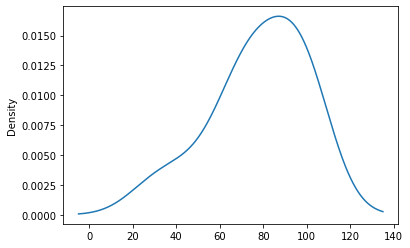

In [40]:
# 2019 14.2 'Potable water coverage'
df = cities_country[1]
df = df[(df[NUM_Q] == '14.2')]
#df[ANS].astype('float64').fillna(df[ANS].mode()[0]).plot.kde()
s = df[ANS].astype('float64')
s = s.fillna(s.mean())
s.plot.kde()

In [29]:
# 2019 14.1 'Water sources'
df = cities_country[1]
df = df[(df[NUM_Q] == '14.1')]
df[ANS].value_counts()

From adjacent river basins (by water transfer schemes) outside the city boundary    8
From a river basin within the city boundary                                         3
Other: Combination of Ground Water and Desalination Plant                           1
Name: Response Answer, dtype: int64

In [26]:
# 2019 6.0 'Opportunities'
df = cities_country[1]
df = df[(df[NUM_Q] == '6.0') & (df[NUM_C] == 1)]
display(df[ANS].value_counts())

Development of energy efficiency measures and technologies    10
Increased energy security                                      5
Increased water security                                       4
Development of tourism industry                                3
Increase in clean technology businesses                        3
Increased attention to other environmental concerns            2
Development of climate change resiliency projects              2
Additional funding opportunities                               2
Development of sustainable transport sector                    2
Development of waste management / recycling businesses         2
Increase opportunities for partnerships                        1
Increased infrastructure investment                            1
Improved efficiency of operations                              1
Name: Response Answer, dtype: int64

In [27]:
# 2019 6.1a 'Business collaboration'
df = cities_country[1]
df = df[(df[NUM_Q] == '6.1a') & (df[NUM_C] == 1)]
df[ANS].value_counts()

Energy                      4
Waste                       3
Transport (Mobility)        2
Water                       2
Agriculture and Forestry    1
Name: Response Answer, dtype: int64

In [28]:
# 2019 6.2 'Emission Reduction projects to attract funding'
df = cities_country[1]
df = df[(df[NUM_Q] == '6.2') & (df[NUM_C].isin([1, 2, 3, 4, 6]))]
for org in np.sort(df['Organization'].unique()):
    display(df[df['Organization'] == org].pivot(index=NUM_R, columns=NAME_C)[ANS])

Column Name,Project area,Project title,Stage of project development,Status of financing,Total cost of project
Row Number,,,,,
0,NaN,NaN,NaN,NaN,NaN


Column Name,Project area,Project title,Stage of project development,Status of financing,Total cost of project
Row Number,,,,,
0,NaN,NaN,NaN,NaN,NaN


Column Name,Project area,Project title,Stage of project development,Status of financing,Total cost of project
Row Number,,,,,
0,NaN,NaN,NaN,NaN,NaN
1,Transport,NaN,Project feasibility,Project partially funded and seeking additiona...,600000


Column Name,Project area,Project title,Stage of project development,Status of financing,Total cost of project
Row Number,,,,,
1,Transport,Chennai Cycle Share Project,Post-implementation,NaN,1000000
2,Transport,Parking Management System,Pre-feasibility,Project not funded and seeking full funding,1400000000


Column Name,Project area,Project title,Stage of project development,Status of financing,Total cost of project
Row Number,,,,,
1,Outdoor lighting,Energy Efficient Solar Street Lights,Transaction preparation,Project partially funded and seeking additiona...,NaN
2,Renewable energy,Smart Grid - Solar Panel PV,Transaction preparation,Project not funded and seeking full funding,NaN
3,Water management,Up-gradation of existing distribution tanks (G...,Project structuring,Project not funded and seeking full funding,NaN
4,Waste management,Smart City Gangtok - Cleanliness,Transaction preparation,Project partially funded and seeking additiona...,NaN


Column Name,Project area,Project title,Stage of project development,Status of financing,Total cost of project
Row Number,,,,,
1,Renewable energy,Floating Solar Power Plant,Project structuring,Project not funded and seeking partial funding,NaN


Column Name,Project area,Project title,Stage of project development,Status of financing,Total cost of project
Row Number,,,,,
1,Outdoor lighting,Installation of Smart LED street lighting with...,Project structuring,Project partially funded and seeking additiona...,68900000
2,Waste management,"Supply, Install, Integration and Maintenance o...",Project structuring,Project not funded and seeking full funding,24300000


Column Name,Project area,Project title,Stage of project development,Status of financing,Total cost of project
Row Number,,,,,
1,Renewable energy,KOCHI SOLAR CITY PROJECT,Project feasibility,Project not funded and seeking partial funding,NaN
2,Transport,Eco Logistics,Pre-feasibility,NaN,NaN
3,Transport,Mobilise Your City,Pre-feasibility,NaN,NaN
4,Buildings,ZERO CARBON BUILDINGS,Project feasibility,NaN,NaN
5,Other: Ecosystem,CITIES 4 FORESTS,Pre-feasibility,NaN,NaN
6,Buildings,Building Efficiency Accelerator,Pre-feasibility,NaN,NaN


Column Name,Project area,Project title,Stage of project development,Status of financing,Total cost of project
Row Number,,,,,
1,Buildings,NaN,NaN,NaN,NaN
2,Renewable energy,NaN,NaN,NaN,NaN
3,Transport,NaN,NaN,NaN,NaN
4,Waste management,NaN,NaN,NaN,NaN
5,Water management,NaN,NaN,NaN,NaN


Column Name,Project area,Project title,Stage of project development,Status of financing,Total cost of project
Row Number,,,,,
0,NaN,NaN,NaN,NaN,NaN


Column Name,Project area,Project title,Stage of project development,Status of financing,Total cost of project
Row Number,,,,,
0,NaN,NaN,NaN,NaN,NaN


Column Name,Project area,Project title,Stage of project development,Status of financing,Total cost of project
Row Number,,,,,
0,NaN,NaN,NaN,NaN,NaN


Column Name,Project area,Project title,Stage of project development,Status of financing,Total cost of project
Row Number,,,,,
0,NaN,NaN,NaN,NaN,NaN
